In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files

In [ ]:
def getLocalFiles():
    _files = files.upload()
    if len(_files) >0:
       for k,v in _files.items():
         open(k,'wb').write(v)
getLocalFiles()

In [3]:
import pandas as pd
import numpy as np
from keras.layers import LSTM, Activation, Dropout, Dense, Input
from keras.layers.embeddings import Embedding
from keras.models import Model, Sequential
from keras.utils import np_utils
import string
import re
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.sequence import pad_sequences
import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.under_sampling import RandomUnderSampler
from datetime import datetime
import pickle

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# tf.debugging.set_log_device_placement(True)

In [4]:
data_us = pd.read_json('/content/drive/My Drive/Master Thesis/Data/train_test_2005_2018_cleaned_us.json')

In [ ]:
uos = RandomUnderSampler(random_state=45)
data_x, data_y = uos.fit_resample(np.array(data['cleaned_text']).reshape(-1,1),np.array(data['stars']).reshape(-1,1))
data_us = pd.DataFrame(list(zip([x[0] for x in data_x], data_y)), columns = ['cleaned_text', 'stars'])

In [5]:
data_us.stars.value_counts()
#data_us.head(1)

1    204237
2    204237
3    204237
4    204237
5    204237
Name: stars, dtype: int64

In [6]:
data_us['stars_reduce'] = data_us['stars']-1

In [7]:
dummy_y = np_utils.to_categorical(data_us.stars_reduce)
dummy_y.shape

(1021185, 5)

In [8]:
X_train, X_test,Y_train, Y_test = train_test_split(data_us.cleaned_text, dummy_y, test_size=0.2, random_state = 45)

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

#words_to_index is the dictionary mapping words to their respective index.
words_to_index = tokenizer.word_index

In [10]:
# saving
with open('/content/drive/My Drive/Master Thesis/Model/keras_lstm_tokenizer_2005_2018.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
maxLen = 300
vocab_len = len(words_to_index)+1
embedding_dim = 64

In [12]:
def lstm_model(input_shape):

  X_indices = Input(input_shape)

  embeddings = Embedding(input_dim=vocab_len, output_dim=embedding_dim, input_length=maxLen)(X_indices)

  X = LSTM(128, return_sequences=True)(embeddings)

  X = Dropout(0.5)(X)

  X = LSTM(128, return_sequences=True)(X)

  X = Dropout(0.5)(X)

  X = LSTM(128, return_sequences=True)(X)

  X = Dropout(0.5)(X)

  X = LSTM(128)(X)

  X = Dropout(0.5)(X)

  X = Dense(5, activation='softmax')(X)

  model = Model(inputs=X_indices, outputs=X)

  return model

In [13]:
model = lstm_model((maxLen,))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding (Embedding)       (None, 300, 64)           11238720  
                                                                 
 lstm (LSTM)                 (None, 300, 128)          98816     
                                                                 
 dropout (Dropout)           (None, 300, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 300, 128)          131584    
                                                                 
 dropout_1 (Dropout)         (None, 300, 128)          0         
                                                                 
 lstm_2 (LSTM)               (None, 300, 128)          131584

In [14]:
X_train_indices = tokenizer.texts_to_sequences(X_train)

X_train_indices = pad_sequences(X_train_indices, maxlen=maxLen, padding='post')

print(X_train_indices.shape)

X_test_indices = tokenizer.texts_to_sequences(X_test)

X_test_indices = pad_sequences(X_test_indices, maxlen=maxLen, padding='post')

(816948, 300)


In [15]:
adam = tf.keras.optimizers.Adam(learning_rate = 1e-4)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
earlystop = EarlyStopping(monitor='val_loss', patience=3)
checkpoint = ModelCheckpoint('/content/drive/My Drive/Master Thesis/Model/keras_lstm_2015_2018_{epoch:02d}-{val_loss:.2f}.h5', save_freq = 'epoch')
epochs=20

In [16]:
start_time = datetime.now()
history = model.fit(X_train_indices, Y_train, validation_data=(X_test_indices, np.asarray(Y_test)), batch_size=64, epochs=epochs, callbacks=[earlystop, checkpoint])
end_time = datetime.now()
print('--- Duration ---{}'.format(end_time - start_time))

Epoch 1/20
12765/12765 [==============================] - 936s 73ms/step - loss: 1.5888 - accuracy: 0.2245 - val_loss: 1.5814 - val_accuracy: 0.2321
Epoch 2/20
12765/12765 [==============================] - 938s 73ms/step - loss: 1.5427 - accuracy: 0.2665 - val_loss: 1.4987 - val_accuracy: 0.2837
Epoch 3/20
12765/12765 [==============================] - 941s 74ms/step - loss: 1.3179 - accuracy: 0.3885 - val_loss: 1.2055 - val_accuracy: 0.4394
Epoch 4/20
12765/12765 [==============================] - 941s 74ms/step - loss: 1.1144 - accuracy: 0.4841 - val_loss: 1.0617 - val_accuracy: 0.5082
Epoch 5/20
12765/12765 [==============================] - 937s 73ms/step - loss: 0.9873 - accuracy: 0.5568 - val_loss: 1.3839 - val_accuracy: 0.4534
Epoch 6/20
12765/12765 [==============================] - 934s 73ms/step - loss: 0.8934 - accuracy: 0.6053 - val_loss: 0.8722 - val_accuracy: 0.6113
Epoch 7/20
12765/12765 [==============================] - 943s 74ms/step - loss: 0.8464 - accuracy: 0.6274

Text(0.5, 1.0, 'Accuracy')

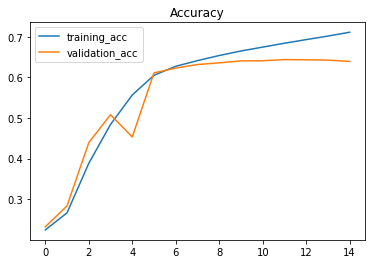

In [17]:
epochs=15
#plot accuracy
# plt.figure(figsize=(15, 7))
plt.plot(range(epochs), history.history['accuracy'])
plt.plot(range(epochs), history.history['val_accuracy'])
plt.legend(['training_acc', 'validation_acc'])
plt.title('Accuracy')

Text(0.5, 1.0, 'Loss')

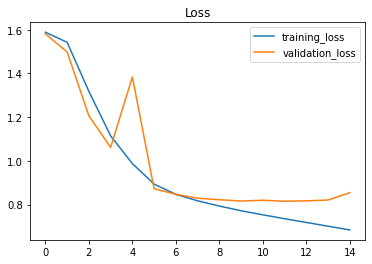

In [18]:
#plot loss
# plt.figure(figsize=(15, 7))
plt.plot(range(epochs), history.history['loss'])
plt.plot(range(epochs), history.history['val_loss'])
plt.legend(['training_loss', 'validation_loss'])
plt.title('Loss')

In [19]:
model.evaluate(X_test_indices, Y_test)

6383/6383 [==============================] - 169s 26ms/step - loss: 0.8541 - accuracy: 0.6395


[0.8540958762168884, 0.6395315527915955]

In [ ]:
model.save('/content/drive/My Drive/Master Thesis/Model/keras_lstm_2015_2018')

In [20]:
loaded_model = keras.models.load_model('/content/drive/My Drive/Master Thesis/Model/keras_lstm_2015_2018_12-0.81.h5')

In [ ]:
np.testing.assert_allclose(
    model.predict(X_test_indices), loaded_model.predict(X_test_indices)
)

In [21]:
data_test = pd.read_json('/content/drive/My Drive/Master Thesis/Data/restaurant_review_2019_cleaned.json')

In [22]:
test_indices = tokenizer.texts_to_sequences(data_test.cleaned_text)

test_indices = pad_sequences(test_indices, maxlen=maxLen, padding='post')

print(test_indices.shape)

(524593, 300)


In [23]:
preds = loaded_model.predict(test_indices)

In [24]:
stars_pred = np.argmax(preds, axis=1)+1

In [25]:
confusion_matrix(data_test.stars, stars_pred)

array([[ 55442,  11065,   1319,    241,    337],
       [ 11443,  21728,   6058,    529,    195],
       [  2871,  12557,  28018,   6316,    886],
       [   756,   1439,  17718,  58490,  22913],
       [  1490,    529,   3590,  58622, 200041]])

In [26]:
print(classification_report(data_test.stars, stars_pred))

              precision    recall  f1-score   support

           1       0.77      0.81      0.79     68404
           2       0.46      0.54      0.50     39953
           3       0.49      0.55      0.52     50648
           4       0.47      0.58      0.52    101316
           5       0.89      0.76      0.82    264272

    accuracy                           0.69    524593
   macro avg       0.62      0.65      0.63    524593
weighted avg       0.72      0.69      0.70    524593



In [27]:
data_test['stars_keras_lstm'] = stars_pred

In [29]:
data_test.head(1)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,restaurant,...,state,postal_code,latitude,longitude,average_stars,review_count,categories,year,cleaned_text,stars_keras_lstm
48,WglA0BSYvc3WBP4I2WpRwA,1_sws6Q8TiR21CzzNvxUiw,XQfwVwDr-v0ZS3_CbbE5Xw,5,0,0,0,I've been here now twice for brunch and the fo...,2019-04-15 01:20:23,Turning Point of North Wales,...,PA,19454,40.210196,-75.223639,3.0,169,"Restaurants, Breakfast & Brunch, Food, Juice B...",2019,I 've be here now twice for brunch and the foo...,5


In [30]:
data_test.to_json('/content/drive/My Drive/Master Thesis/Data/restaurant_review_2019_cleaned_prediction.json')